<p style="text-align: center;"><img alt="school-logo" src="../images/school_logo.png" style="zoom: 50%;" /></p>

<h1 align="center">本科生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">卷积神经网络实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">21281280</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">班级</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">物联网2101班</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">指导老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">张淳杰</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2023年12月10日</span></div>
</div>

实验环境：
- OS：Ubuntu 22.04.3 LTS (GNU/Linux 6.2.0-37-generic x86_64)
- CPU：12th Gen Intel(R) Core(TM) i7-12700H
- GPU：NVIDIA GeForce RTX 3070 Ti Laptop
- cuda: 12.3
- conda: miniconda 23.9.0
- python：3.10.13
- torch：2.1.1

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt

# 0. 数据集

## 0.1. 车辆分类数据集

- 输入图片，输出对应的类别
- 共1358张车辆图片
- 分别属于汽车、客车和货车三类
    - 汽车：779张
    - 客车：218张
    - 货车：360张
- 每个类别随机取20-30%当作测试集
- 各图片的大小不一，需要将图片拉伸到相同大小

对于原数据集进行`8:2`划分处理。将各个类别的数据分别进行划分。

In [2]:
train_list = list()
test_list = list()

root_dir = "raw"
class_index = 0
for vehicle in os.listdir(os.path.join("./dataset/Vehicles", root_dir)):
    img_list = [i for i in os.listdir(os.path.join("./dataset/Vehicles", root_dir, vehicle)) if i.endswith(".jpg")]
    random.shuffle(img_list)
    split_num = int(len(img_list) * 0.8)
    for img in img_list[0 : split_num]:
        train_list.append([os.path.join(root_dir, vehicle, img), class_index])
    for img in img_list[split_num : ]:
        test_list.append([os.path.join(root_dir, vehicle, img), class_index])
    class_index += 1

train_list.sort()
test_list.sort()

df_train = pd.DataFrame(data=train_list, columns=["Vehicle", "Label"])
df_train.to_csv("./dataset/Vehicles/train.csv", index=False)
df_test = pd.DataFrame(data=test_list, columns=["Vehicle", "Label"])
df_test.to_csv("./dataset/Vehicles/test.csv", index=False)

print("训练数据集列表：")
print(df_train)
print()
print("测试数据集列表：")
print(df_test)

训练数据集列表：
                     Vehicle  Label
0         raw/bus/bus001.jpg      1
1         raw/bus/bus003.jpg      1
2         raw/bus/bus004.jpg      1
3         raw/bus/bus006.jpg      1
4         raw/bus/bus007.jpg      1
...                      ...    ...
1080  raw/truck/truck355.jpg      2
1081  raw/truck/truck356.jpg      2
1082  raw/truck/truck357.jpg      2
1083  raw/truck/truck358.jpg      2
1084  raw/truck/truck359.jpg      2

[1085 rows x 2 columns]

测试数据集列表：
                    Vehicle  Label
0        raw/bus/bus002.jpg      1
1        raw/bus/bus005.jpg      1
2        raw/bus/bus008.jpg      1
3        raw/bus/bus017.jpg      1
4        raw/bus/bus019.jpg      1
..                      ...    ...
267  raw/truck/truck329.jpg      2
268  raw/truck/truck333.jpg      2
269  raw/truck/truck335.jpg      2
270  raw/truck/truck345.jpg      2
271  raw/truck/truck360.jpg      2

[272 rows x 2 columns]


自定义`Dataset`类`Vehicle`，供训练调用。

训练数据集的第1对数据：
x[0]第1个特征维度数据x[0]的大小 = torch.Size([3, 120, 85])
y[0] = 1
x[0]的图像：


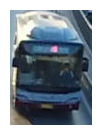

测试数据集的第1对数据：
x[0]第1个特征维度数据x[0]的大小 = torch.Size([3, 195, 140])
y[0] = 1
x[0]的图像：


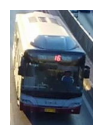

In [3]:
class Vehicle(Dataset):
    def __init__(self, root:str="../dataset", train:bool=True, transform=None):
        root = os.path.join(root, "Vehicles")
        csv_file = os.path.join(root, "train.csv" if train else "test.csv")
        self.data = pd.read_csv(csv_file).to_numpy().tolist()
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_name, label = self.data[index]
        img_path = os.path.join(self.root, img_name)
        image = Image.open(img_path)
        label = int(label)
        if self.transform:
            image = self.transform(image)
        return image, label


# 显示图片函数
def imshow(img_list:list, name_list:list[str]=None, size=1.5):
    img_num = len(img_list)
    plt.figure(figsize=(size * img_num, size))
    for i in range(img_num):
        img = img_list[i]
        img = img.permute(1, 2, 0).numpy()
        plt.subplot(1, img_num, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if name_list is not None:
            plt.title(name_list[i])
    plt.show()


# 测试
vehicle_train = Vehicle(root="./dataset", train=True, transform=transforms.ToTensor())
vehicle_test = Vehicle(root="./dataset", train=False, transform=transforms.ToTensor())
x0, y0 = vehicle_train[0]
print(f"训练数据集的第1对数据：")
print(f"x[0]第1个特征维度数据x[0]的大小 = {x0.shape}")
print(f"y[0] = {y0}")
print(f"x[0]的图像：")
imshow([x0])

x1, y1 = vehicle_test[0]
print(f"测试数据集的第1对数据：")
print(f"x[0]第1个特征维度数据x[0]的大小 = {x1.shape}")
print(f"y[0] = {y1}")
print(f"x[0]的图像：")
imshow([x1])

## 0.2. 照片去雾数据集

- 输入带雾图片，输出去雾图片
- 共520张图片
- 随机取20%的图片当作测试集
- 各图片的大小不一，需要将图片拉伸到相同大小

对于原数据集进行`8:2`划分处理。



In [4]:
train_list = set()

img_list = [i for i in os.listdir("./dataset/Haze/raw/haze") if i.endswith(".jpg")]
random.shuffle(img_list)
for img in img_list[ : int(len(img_list) * 0.8)]:
    train_list.add(img)
img_list.sort()
data = list()
for img in img_list:
    data.append([img, 1 if img in train_list else 0])

df = pd.DataFrame(data=data, columns=["Image", "Train"])
df.to_csv("./dataset/Haze/split.csv", index=False)

print(df)

       Image  Train
0    001.jpg      1
1    002.jpg      1
2    003.jpg      1
3    004.jpg      0
4    005.jpg      0
..       ...    ...
515  516.jpg      1
516  517.jpg      1
517  518.jpg      1
518  519.jpg      1
519  520.jpg      0

[520 rows x 2 columns]


自定义`Dataset`类`Haze`，供训练调用。

训练数据集的第1对数据：
x[0]第1个特征维度数据x[0]的大小 = torch.Size([3, 413, 550])
y[0]第1个特征维度数据y[0]的大小 = torch.Size([3, 413, 550])
x[0]和y[0]的图像：


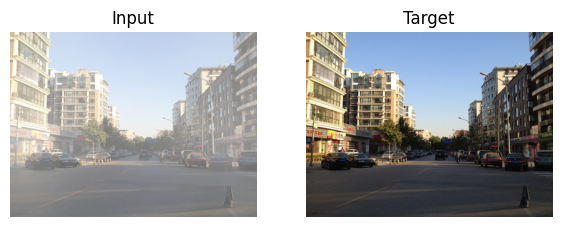

测试数据集的第1对数据：
x[0]第1个特征维度数据x[0]的大小 = torch.Size([3, 604, 549])
y[0]第1个特征维度数据y[0]的大小 = torch.Size([3, 604, 549])
x[0]和y[0]的图像：


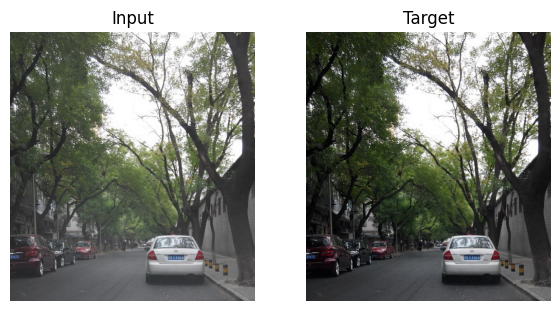

In [5]:
class Haze(Dataset):
    def __init__(self, root:str="../dataset", train:bool=True, transform=None):
        root = os.path.join(root, "Haze")
        split_file = pd.read_csv(os.path.join(root, "split.csv")).to_numpy().tolist()
        self.data = list()
        for img, is_train in split_file:
            if train and int(is_train) == 1:
                self.data.append(img)
            elif not train and int(is_train) == 0:
                self.data.append(img)
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_name = self.data[index]
        img_path = os.path.join(self.root, "raw/haze", img_name)
        ground_truth_path = os.path.join(self.root, "raw/no_haze", img_name)
        image = Image.open(img_path)
        ground_truth = Image.open(ground_truth_path)
        if self.transform:
            image = self.transform(image)
            ground_truth = self.transform(ground_truth)
        return image, ground_truth


# 测试
haze_train = Haze(root="./dataset", train=True, transform=transforms.ToTensor())
haze_test = Haze(root="./dataset", train=False, transform=transforms.ToTensor())
x0, y0 = haze_train[0]
print(f"训练数据集的第1对数据：")
print(f"x[0]第1个特征维度数据x[0]的大小 = {x0.shape}")
print(f"y[0]第1个特征维度数据y[0]的大小 = {y0.shape}")
print(f"x[0]和y[0]的图像：")
imshow([x0, y0], ["Input", "Target"], size=3.5)

x1, y1 = haze_test[0]
print(f"测试数据集的第1对数据：")
print(f"x[0]第1个特征维度数据x[0]的大小 = {x1.shape}")
print(f"y[0]第1个特征维度数据y[0]的大小 = {y1.shape}")
print(f"x[0]和y[0]的图像：")
imshow([x1, y1], ["Input", "Target"], size=3.5)

# 1. 二维卷积实验

- 手写二维卷积的实现，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）（只用循环几轮即可）
- 使用torch.nn实现二维卷积，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）
- 不同超参数的对比分析（包括卷积层数、卷积核大小、batchsize、lr等）选其中至少1-2个进行分析


对应两个数据集，首先分别定义好训练框架函数，将模型、`learning_rate`和`batch_size`等作为参数传入即可。

In [6]:
def train_Vehicle_CLS(model:nn.Module, learning_rate=1e-3, batch_size=64, num_epochs=51):
    num_classes = 3
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((32, 32), antialias=True),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    train_dataset = Vehicle(root="./dataset", train=True, transform=transform)
    test_dataset = Vehicle(root="./dataset", train=False, transform=transform)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=14, pin_memory=True)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = list()
    test_acc = list()
    for epoch in range(num_epochs):
        model.train()
        total_epoch_loss = 0
        train_tik = time.time()
        for index, (images, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            images = images.to(device)
            targets = targets.to(device)
            one_hot_targets = F.one_hot(targets, num_classes=num_classes).to(dtype=torch.float)

            outputs = model(images)
            loss = criterion(outputs, one_hot_targets)
            total_epoch_loss += loss.item()

            loss.backward()
            optimizer.step()
        train_tok = time.time()

        model.eval()
        with torch.no_grad():
            total_epoch_acc = 0
            test_tik = time.time()
            for index, (image, targets) in enumerate(test_loader):
                image = image.to(device)
                targets = targets.to(device)

                outputs = model(image)
                pred = F.softmax(outputs, dim=1)
                total_epoch_acc += (pred.argmax(1) == targets).sum().item()
            test_tok = time.time()

        avg_epoch_acc = total_epoch_acc / len(test_dataset)
        if epoch % 15 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}],",
                f"Train Loss: {total_epoch_loss:.10f},",
                f"Train Time: {1000 * (train_tok - train_tik):.2f}ms,",
                f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
                f"Test Time: {1000 * (test_tok - test_tik):.2f}ms"
            )
        train_loss.append(total_epoch_loss)
        test_acc.append(avg_epoch_acc)
    print(f"最大显存使用量: {torch.cuda.max_memory_allocated() / (1024 * 1024):.2f}MiB")
    torch.cuda.reset_peak_memory_stats()
    return train_loss, test_acc


def train_Haze_Removal(model:nn.Module, learning_rate=1e-3, batch_size=64, num_epochs=51):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
        ]
    )
    train_dataset = Haze(root="./dataset", train=True, transform=transform)
    test_dataset = Haze(root="./dataset", train=False, transform=transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=14, pin_memory=True)

    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = list()
    test_loss = list()
    for epoch in range(num_epochs):
        model.train()
        total_epoch_train_loss = 0
        train_tik = time.time()
        for index, (images, ground_truth) in enumerate(train_loader):
            optimizer.zero_grad()

            images = images.to(device)
            ground_truth = ground_truth.to(device)

            outputs = model(images)
            loss = criterion(outputs, ground_truth)
            total_epoch_train_loss += loss.item()

            loss.backward()
            optimizer.step()
        train_tok = time.time()

        model.eval()
        with torch.no_grad():
            total_epoch_test_loss = 0
            test_tik = time.time()
            for index, (image, ground_truth) in enumerate(test_loader):
                image = image.to(device)
                ground_truth = ground_truth.to(device)

                outputs = model(image)
                loss = criterion(outputs, ground_truth)
                total_epoch_test_loss += loss.item()
            test_tok = time.time()

        if epoch % 15 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}],",
                f"Train Loss: {total_epoch_train_loss:.10f},",
                f"Train Time: {1000 * (train_tok - train_tik):.2f}ms,",
                f"Test Loss: {total_epoch_test_loss:.10f},",
                f"Test Time: {1000 * (test_tok - test_tik):.2f}ms"
            )
        train_loss.append(total_epoch_train_loss)
        test_loss.append(total_epoch_test_loss)
    print(f"最大显存使用量: {torch.cuda.max_memory_allocated() / (1024 * 1024):.2f}MiB")
    torch.cuda.reset_peak_memory_stats()
    return train_loss, test_loss

## 1.1. 手写二维卷积

在传统的二维卷积中，卷积是通过一个滑动的卷积核进行计算的，这就意味着会有大量的`for`循环，会增加计算的时间复杂度。

对于拥有良好矩阵运算性能的GPU来说，上面的计算可以进行优化，即：将卷积核转化为矩阵，原图像数据也裁剪成对应的矩阵，叠加起来，这样需要多层`for`循环的卷积运算就可以由一次矩阵运算完成。

具体运算流程如下：
1. 将原图像进行`padding`操作；
2. 使用`nn.functional.unfold()`将原图像矩阵重塑为`(batch_size, -1, in_channels, kernel_size, kernel_size)`，其中`-1`会被替代为每张图片裁剪成了多少块，等于传统二维卷积的卷积核循环滑动计算次数；
3. 将卷积核重塑为对应图片碎块的卷积核矩阵；
4. 将两者进行矩阵相乘，一次计算完毕，加上偏置`bias`；
5. 重塑相乘结果，转化为正确的输出矩阵。

代码实现如下。

In [7]:
class My_Conv2d(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, kernel_size:int, padding:int=0, bias=True):
        super(My_Conv2d, self).__init__()
        self.has_bias = bias
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        nn.init.xavier_uniform_(self.weight)
        if self.has_bias:
            self.bias = nn.Parameter(torch.zeros(out_channels, requires_grad=True, dtype=torch.float32))

    def forward(self, x):
        batch_size, _, input_height, input_width = x.shape
        if self.padding > 0:
            x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))
        x = F.unfold(x, kernel_size=self.kernel_size)
        x = x.permute(0, 2, 1).contiguous()
        weight_unfold = self.weight.view(self.out_channels, -1).t()
        x = torch.matmul(x, weight_unfold)
        if self.has_bias:
            x += self.bias
        output_height = input_height + 2 * self.padding - self.kernel_size + 1
        output_width = input_width + 2 * self.padding - self.kernel_size + 1
        x = x.view(batch_size, output_height, output_width, self.out_channels).permute(0, 3, 1, 2).contiguous()
        return x

## 1.2. `torch.nn`实现二维卷积

使用上面定义的二维卷积进行车辆分类的训练和预测。

同时，使用`nn.Conv2d`组建相同结构的模型，与手写二维卷积组建的模型进行比较。

使用手写二维卷积进行训练：
Epoch [1/61], Train Loss: 4.2001484036, Train Time: 1532.61ms, Test Acc: 73.162%, Test Time: 310.06ms
Epoch [16/61], Train Loss: 2.2175552249, Train Time: 1311.45ms, Test Acc: 82.721%, Test Time: 315.75ms
Epoch [31/61], Train Loss: 1.7417621315, Train Time: 1326.53ms, Test Acc: 85.294%, Test Time: 313.40ms
Epoch [46/61], Train Loss: 1.4466003180, Train Time: 1339.23ms, Test Acc: 88.235%, Test Time: 326.99ms
Epoch [61/61], Train Loss: 1.0578760803, Train Time: 1334.05ms, Test Acc: 88.235%, Test Time: 315.67ms
最大显存使用量: 3767.54MiB

使用nn.Conv2d进行训练：
Epoch [1/61], Train Loss: 4.0539320707, Train Time: 806.85ms, Test Acc: 57.353%, Test Time: 279.37ms
Epoch [16/61], Train Loss: 2.2494921982, Train Time: 743.27ms, Test Acc: 81.618%, Test Time: 276.17ms
Epoch [31/61], Train Loss: 1.5827169418, Train Time: 745.45ms, Test Acc: 88.603%, Test Time: 284.74ms
Epoch [46/61], Train Loss: 1.3525357991, Train Time: 743.16ms, Test Acc: 85.294%, Test Time: 277.20ms
Epoch [61/61], Train Loss: 

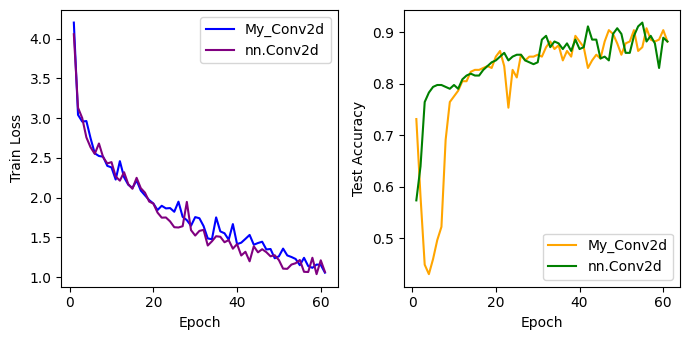

In [8]:
class Model_Vehicle_CLS_1_1(nn.Module):
    def __init__(self, num_classes=3):
        super(Model_Vehicle_CLS_1_1, self).__init__()
        self.conv1 = My_Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = My_Conv2d(in_channels=128, out_channels=512, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(512)
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.avg_pool2d(x, 32)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class Model_Vehicle_CLS_1_2(nn.Module):
    def __init__(self, num_classes=3):
        super(Model_Vehicle_CLS_1_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(512)
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.avg_pool2d(x, 32)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


if __name__ == "__main__":
    num_epochs = 61
    learning_rate = 4e-4
    batch_size = 256
    plt.figure(figsize=(7, 3.5))
    print("使用手写二维卷积进行训练：")
    my_conv_model = Model_Vehicle_CLS_1_1(num_classes=3)
    train_loss, test_acc = train_Vehicle_CLS(model=my_conv_model, learning_rate=learning_rate,
                                             batch_size=batch_size, num_epochs=num_epochs)
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_loss, label=f'My_Conv2d', color='blue')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_acc, label=f'My_Conv2d', color='orange')
    torch.cuda.empty_cache()
    print()
    
    print("使用nn.Conv2d进行训练：")
    nn_conv_model = Model_Vehicle_CLS_1_2(num_classes=3)
    train_loss, test_acc = train_Vehicle_CLS(model=nn_conv_model, learning_rate=learning_rate,
                                             batch_size=batch_size, num_epochs=num_epochs)
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_loss, label=f'nn.Conv2d', color='purple')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_acc, label=f'nn.Conv2d', color='green')
    torch.cuda.empty_cache()

    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

很显然，在车辆分类的任务上，手动实现的二维卷积能够完成任务，正确率和`nn.Conv2d`相差不大。

但是`nn.Conv2d`的优化显然比手动实现的好，每个epoch的训练用时和显存占用情况都优于手动实现的二维卷积。

接下来设计和训练卷积神经网络完成图片去雾任务。同样的，使用手写二维卷积和`nn.Conv2d`进行比较实验。

Epoch [1/61], Train Loss: 9.7143820152, Train Time: 7662.28ms, Test Loss: 0.2254622690, Test Time: 892.87ms
Epoch [16/61], Train Loss: 0.2670321050, Train Time: 7814.79ms, Test Loss: 0.0624035411, Test Time: 905.79ms
Epoch [31/61], Train Loss: 0.2587767891, Train Time: 7701.26ms, Test Loss: 0.2160127331, Test Time: 919.30ms
Epoch [46/61], Train Loss: 0.1850438942, Train Time: 7700.98ms, Test Loss: 0.0376524224, Test Time: 940.56ms
Epoch [61/61], Train Loss: 0.1704676794, Train Time: 7719.27ms, Test Loss: 0.0438697226, Test Time: 915.84ms
最大显存使用量: 5740.40MiB

Epoch [1/61], Train Loss: 2.2550467588, Train Time: 1707.42ms, Test Loss: 0.1053516669, Test Time: 501.23ms
Epoch [16/61], Train Loss: 0.2141725062, Train Time: 1782.16ms, Test Loss: 0.0994708389, Test Time: 483.66ms
Epoch [31/61], Train Loss: 0.1971579930, Train Time: 1676.91ms, Test Loss: 0.0728405030, Test Time: 485.45ms
Epoch [46/61], Train Loss: 0.1555373422, Train Time: 1757.11ms, Test Loss: 0.0368637671, Test Time: 477.95ms


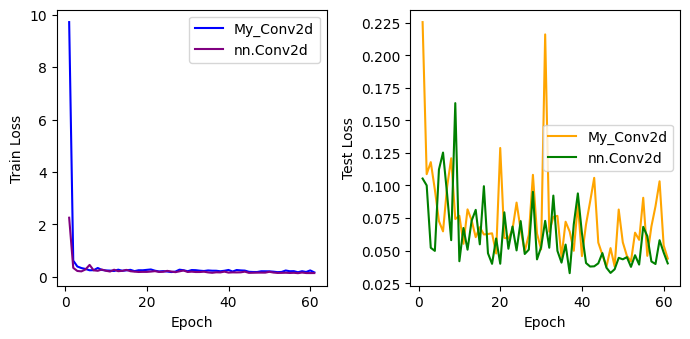

单张图片测试：


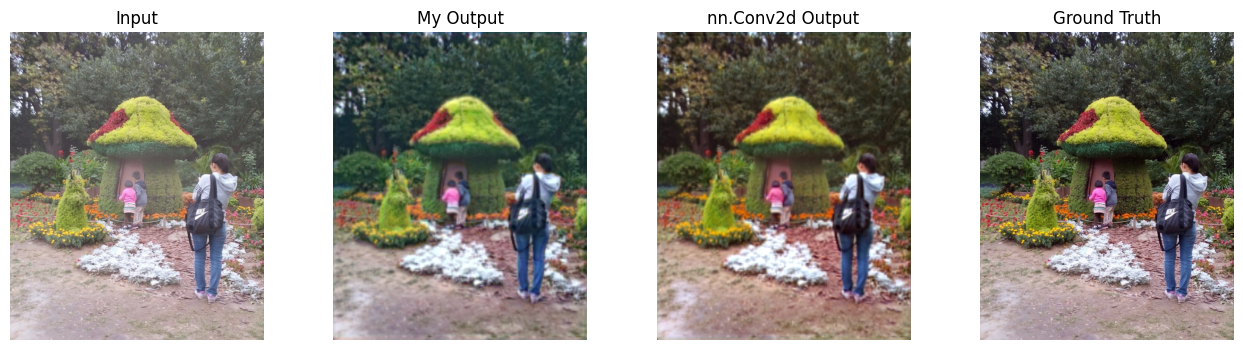

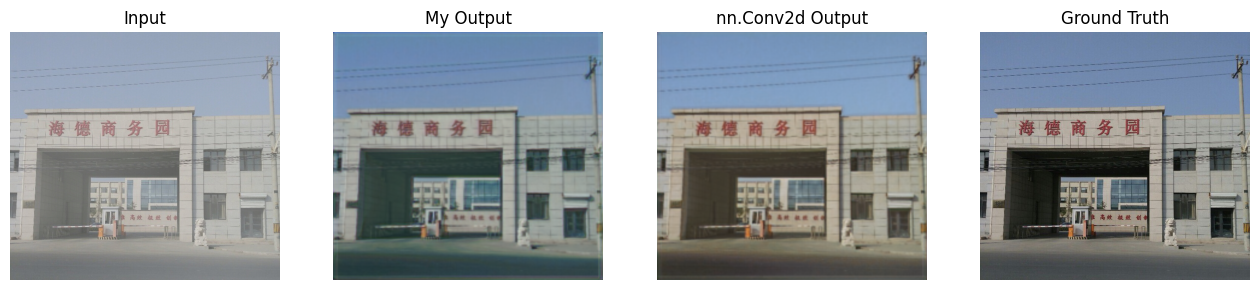

In [9]:
class Model_Haze_Removal_1_1(nn.Module):
    def __init__(self):
        super(Model_Haze_Removal_1_1, self).__init__()
        self.conv1 = My_Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = My_Conv2d(in_channels=16, out_channels=48, kernel_size=5, padding=2, bias=False)
        self.bn2 = nn.BatchNorm2d(48)
        self.conv3 = My_Conv2d(in_channels=48, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.conv3(x)
        return x
        

class Model_Haze_Removal_1_2(nn.Module):
    def __init__(self):
        super(Model_Haze_Removal_1_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=48, kernel_size=5, padding=2, bias=False)
        self.bn2 = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.conv3(x)
        return x


if __name__ == "__main__":
    num_epochs = 61
    learning_rate = 5e-3
    batch_size = 16
    device = "cuda" if torch.cuda.is_available() else "cpu"
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
        ]
    )
    
    plt.figure(figsize=(7, 3.5))
    model = Model_Haze_Removal_1_1()
    train_loss, test_loss = train_Haze_Removal(model=model, learning_rate=learning_rate,
                                               batch_size=batch_size, num_epochs=num_epochs)
    with torch.no_grad():
        input_img1 = Image.open("./dataset/Haze/raw/haze/003.jpg")
        input_img1 = transform(input_img1).to(device)
        my_output_img1 = model(input_img1.unsqueeze(0)).squeeze().cpu()
        input_img2 = Image.open("./dataset/Haze/raw/haze/520.jpg")
        input_img2 = transform(input_img2).to(device)
        my_output_img2 = model(input_img2.unsqueeze(0)).squeeze().cpu()
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_loss, label=f'My_Conv2d', color='blue')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_loss, label=f'My_Conv2d', color='orange')
    torch.cuda.empty_cache()
    print()
    
    model = Model_Haze_Removal_1_2()
    train_loss, test_loss = train_Haze_Removal(model=model, learning_rate=learning_rate,
                                               batch_size=batch_size, num_epochs=num_epochs)
    with torch.no_grad():
        input_img1 = Image.open("./dataset/Haze/raw/haze/003.jpg")
        input_img1 = transform(input_img1).to(device)
        nn_output_img1 = model(input_img1.unsqueeze(0)).squeeze().cpu()
        input_img2 = Image.open("./dataset/Haze/raw/haze/520.jpg")
        input_img2 = transform(input_img2).to(device)
        nn_output_img2 = model(input_img2.unsqueeze(0)).squeeze().cpu()
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_loss, label=f'nn.Conv2d', color='purple')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_loss, label=f'nn.Conv2d', color='green')
    torch.cuda.empty_cache()
    
    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("单张图片测试：")
    input_img1 = Image.open("./dataset/Haze/raw/haze/003.jpg")
    input_img1 = transforms.ToTensor()(input_img1)
    input_img2 = Image.open("./dataset/Haze/raw/haze/520.jpg")
    input_img2 = transforms.ToTensor()(input_img2)
    ground_truth_img1 = Image.open("./dataset/Haze/raw/no_haze/003.jpg")
    ground_truth_img2 = Image.open("./dataset/Haze/raw/no_haze/520.jpg")
    my_output_img1 = transforms.Resize((ground_truth_img1.size[1], ground_truth_img1.size[0]), antialias=True)(my_output_img1).clamp(0, 1)
    my_output_img2 = transforms.Resize((ground_truth_img2.size[1], ground_truth_img2.size[0]), antialias=True)(my_output_img2).clamp(0, 1)
    nn_output_img1 = transforms.Resize((ground_truth_img1.size[1], ground_truth_img1.size[0]), antialias=True)(nn_output_img1).clamp(0, 1)
    nn_output_img2 = transforms.Resize((ground_truth_img2.size[1], ground_truth_img2.size[0]), antialias=True)(nn_output_img2).clamp(0, 1)
    ground_truth_img1 = transforms.ToTensor()(ground_truth_img1)
    ground_truth_img2 = transforms.ToTensor()(ground_truth_img2)
    imshow(
        [input_img1, my_output_img1, nn_output_img1, ground_truth_img1],
        ["Input", "My Output", "nn.Conv2d Output", "Ground Truth"],
        size=4
    )
    imshow(
        [input_img2, my_output_img2, nn_output_img2, ground_truth_img2],
        ["Input", "My Output", "nn.Conv2d Output", "Ground Truth"],
        size=4
    )

在本任务中，没有全连接层的干扰，手写二维卷积与`nn.Conv2d`的差距更加明显，前者的训练用时几乎是后者的5倍，显存占用是后者的7倍。

从单张图片测试结果来看，卷积神经网络能够完成去雾问题，但是输出图像分辨率严重下降。因为在卷积的过程中，原图像信息有所丢失，考虑使用残差网络可能会缓解这个问题。另外，发现图像边缘有黑边，猜测是由`padding`导致的。

## 1.3. 超参数比较分析

接下来从**卷积层数**进行对比分析。分别构造具有1、2、3、4个卷积层的模型，进行车辆分类任务的训练和预测。为控制变量，卷积层的输出统一为512个特征，变量为卷积层层数和各卷积层之间out_channels的大小分配。

卷积层层数=1
Epoch [1/61], Train Loss: 5.3278567791, Train Time: 455.80ms, Test Acc: 57.353%, Test Time: 280.53ms
Epoch [16/61], Train Loss: 4.1107245684, Train Time: 440.53ms, Test Acc: 61.029%, Test Time: 286.89ms
Epoch [31/61], Train Loss: 3.9744439125, Train Time: 440.26ms, Test Acc: 65.074%, Test Time: 271.23ms
Epoch [46/61], Train Loss: 3.6898279190, Train Time: 453.84ms, Test Acc: 70.588%, Test Time: 271.92ms
Epoch [61/61], Train Loss: 3.5916117430, Train Time: 443.55ms, Test Acc: 72.059%, Test Time: 272.47ms
最大显存使用量: 2077.51MiB

卷积层层数=2
Epoch [1/61], Train Loss: 4.4793834090, Train Time: 776.41ms, Test Acc: 58.088%, Test Time: 310.68ms
Epoch [16/61], Train Loss: 2.2433527112, Train Time: 792.15ms, Test Acc: 82.721%, Test Time: 300.90ms
Epoch [31/61], Train Loss: 1.7684264183, Train Time: 766.23ms, Test Acc: 85.294%, Test Time: 298.98ms
Epoch [46/61], Train Loss: 1.5941062272, Train Time: 771.07ms, Test Acc: 86.765%, Test Time: 324.52ms
Epoch [61/61], Train Loss: 1.3803054094, Train 

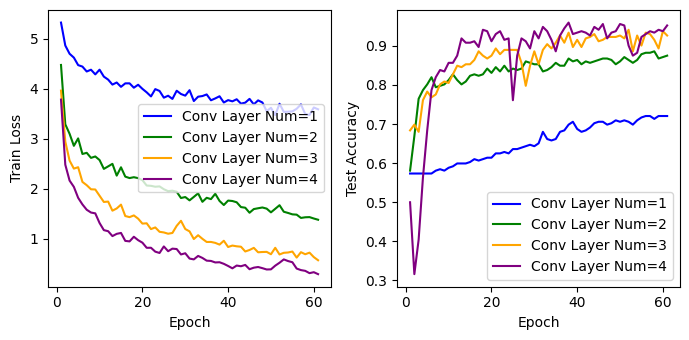

In [10]:
class Model_Vehicle_CLS_1_3_1(nn.Module):
    def __init__(self, num_classes=3):
        super(Model_Vehicle_CLS_1_3_1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
        )
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, 32)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class Model_Vehicle_CLS_1_3_2(nn.Module):
    def __init__(self, num_classes=3):
        super(Model_Vehicle_CLS_1_3_2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
        )
        self.fc = nn.Linear(in_features=512, out_features=num_classes, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, 32)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class Model_Vehicle_CLS_1_3_3(nn.Module):
    def __init__(self, num_classes=3):
        super(Model_Vehicle_CLS_1_3_3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
        )
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.avg_pool2d(x, 32)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class Model_Vehicle_CLS_1_3_4(nn.Module):
    def __init__(self, num_classes=3):
        super(Model_Vehicle_CLS_1_3_4, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
        )
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.avg_pool2d(x, 32)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


if __name__ == "__main__":
    num_epochs = 61
    learning_rate = 2e-4
    batch_size = 256
    plt.figure(figsize=(7, 3.5))
    color = ["blue", "green", "orange", "purple"]
    models = [
        Model_Vehicle_CLS_1_3_1, 
        Model_Vehicle_CLS_1_3_2,
        Model_Vehicle_CLS_1_3_3,
        Model_Vehicle_CLS_1_3_4,
    ]
    for i in range(4):
        model = models[i]()
        print(f"卷积层层数={i + 1}")
        train_loss, test_acc = train_Vehicle_CLS(model=model, learning_rate=learning_rate,
                                                 batch_size=batch_size, num_epochs=num_epochs)
        print()
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_loss, label=f'Conv Layer Num={i + 1}', color=color[i])
        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), test_acc, label=f'Conv Layer Num={i + 1}', color=color[i])
        torch.cuda.empty_cache()
    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

模型训练的显存占用、单个epoch的训练/测试时长都随着卷积层的数量增加而增加。

从曲线上看，模型训练的稳定程度随着卷积层数量的增加而增加。

当卷积层数量逐渐增加，正确率提高，说明模型的拟合能力也逐渐提高。

对**卷积核大小**进行比较分析。分别构造卷积核大小为3、5、7、9的模型，进行图片去雾任务的训练和预测。

卷积核大小=3
Epoch [1/61], Train Loss: 3.1439362988, Train Time: 2316.55ms, Test Loss: 0.1290322095, Test Time: 954.82ms
Epoch [16/61], Train Loss: 0.0528475945, Train Time: 2244.04ms, Test Loss: 0.0193232223, Test Time: 953.56ms
Epoch [31/61], Train Loss: 0.0459665079, Train Time: 2134.88ms, Test Loss: 0.0186642064, Test Time: 945.18ms
Epoch [46/61], Train Loss: 0.0403150846, Train Time: 2225.28ms, Test Loss: 0.0128544462, Test Time: 971.95ms
Epoch [61/61], Train Loss: 0.0430518123, Train Time: 2147.37ms, Test Loss: 0.0130935577, Test Time: 949.75ms
最大显存使用量: 3025.99MiB

卷积核大小=5
Epoch [1/61], Train Loss: 22.0679017007, Train Time: 2665.19ms, Test Loss: 0.4971005619, Test Time: 994.13ms
Epoch [16/61], Train Loss: 0.0938065071, Train Time: 2612.36ms, Test Loss: 0.0260655442, Test Time: 1010.52ms
Epoch [31/61], Train Loss: 0.0709789190, Train Time: 2676.67ms, Test Loss: 0.0205643894, Test Time: 1005.72ms
Epoch [46/61], Train Loss: 0.0653307587, Train Time: 2631.53ms, Test Loss: 0.0186872026, T

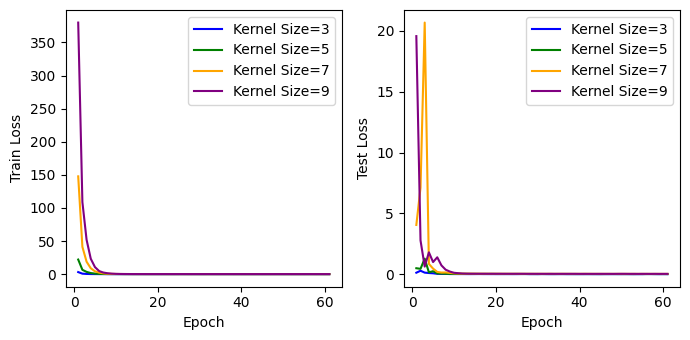

单张图片测试：


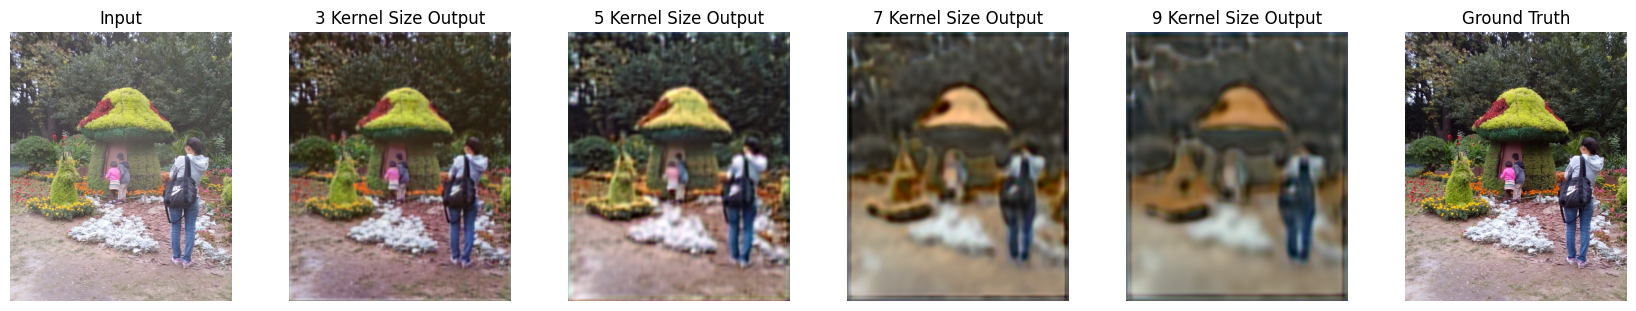

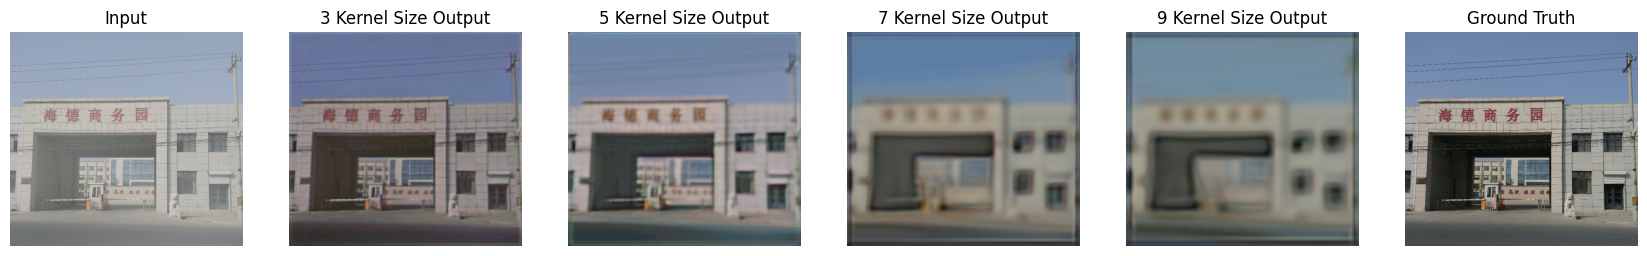

In [11]:
class Model_Haze_Removal_1_3_1(nn.Module):
    def __init__(self):
        super(Model_Haze_Removal_1_3_1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=48, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(48),
        )
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x


class Model_Haze_Removal_1_3_2(nn.Module):
    def __init__(self):
        super(Model_Haze_Removal_1_3_2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(16),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=48, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(48),
        )
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=3, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x


class Model_Haze_Removal_1_3_3(nn.Module):
    def __init__(self):
        super(Model_Haze_Removal_1_3_3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=48, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=3, kernel_size=7, padding=3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x


class Model_Haze_Removal_1_3_4(nn.Module):
    def __init__(self):
        super(Model_Haze_Removal_1_3_4, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9, padding=4, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=48, kernel_size=9, padding=4, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=3, kernel_size=9, padding=4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

if __name__ == "__main__":
    num_epochs = 61
    learning_rate = 8e-3
    batch_size = 64
    plt.figure(figsize=(7, 3.5))
    color = ["blue", "green", "orange", "purple"]
    models = [
        Model_Haze_Removal_1_3_1, 
        Model_Haze_Removal_1_3_2, 
        Model_Haze_Removal_1_3_3, 
        Model_Haze_Removal_1_3_4, 
    ]
    test_imgs = [
        ["./dataset/Haze/raw/haze/003.jpg", "./dataset/Haze/raw/haze/520.jpg"], 
        ["./dataset/Haze/raw/no_haze/003.jpg", "./dataset/Haze/raw/no_haze/520.jpg"],
    ]
    output_imgs = []
    for i in range(4):
        model = models[i]()
        print(f"卷积核大小={3 + 2 * i}")
        train_loss, test_loss = train_Haze_Removal(model=model, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)
        print()
        with torch.no_grad():
            model_output_imgs = []
            for test_img in test_imgs[0]:
                input_img = Image.open(test_img)
                input_img = transform(input_img).to(device)
                output_img = model(input_img.unsqueeze(0)).squeeze().cpu()
                model_output_imgs.append(output_img)
            output_imgs.append(model_output_imgs)
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_loss, label=f'Kernel Size={3 + 2 * i}', color=color[i])
        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), test_loss, label=f'Kernel Size={3 + 2 * i}', color=color[i])
        torch.cuda.empty_cache()
    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("单张图片测试：")
    for i in range(len(test_imgs[0])):
        show_imgs = []
        test_img = test_imgs[0][i]
        input_img = Image.open(test_img)
        show_imgs.append(transforms.ToTensor()(input_img))
        labels = ["Input"]
        for j in range(4):
            output_img = output_imgs[j][i]
            output_img = transforms.Resize((input_img.size[1], input_img.size[0]), antialias=True)(output_img).clamp(0, 1)
            show_imgs.append(output_img)
            labels += [f"{3 + 2 * j} Kernel Size Output"]
        ground_truth_img = Image.open(test_imgs[1][i])
        ground_truth_img = transforms.ToTensor()(ground_truth_img)
        show_imgs.append(ground_truth_img)
        labels += ["Ground Truth"]
        imshow(show_imgs, labels, size=3.5)

随着卷积核的增大，单个epoch的训练/测试时长增加，显存占用也增加。

从单张图片的测试来看，不同卷积核大小的模型均能提升图片的对比度，即让白雾蒙住的黑暗处恢复阴影。

随着卷积核尺寸的增大，输出图片变模糊。这是因为卷积核的感受野增大，损失信息增多。

另外还发现，卷积核越小，在相同训练条件下，模型越能保留图像原有的颜色。随着卷积核尺寸的增大，图像发黄，可能是由于批归一化的原因，也有可能是因为每个像素点收到了了周围像素点的影响，颜色也趋同于周围的颜色，而颜色的平均值相较于原来的颜色偏黄。

# 2. 空洞卷积实验

- 使用torch.nn实现空洞卷积，要求dilation满足HDC条件（如1,2,5）且要堆叠多层并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）
- 将空洞卷积模型的实验结果与卷积模型的结果进行分析比对，训练时间、预测精度、Loss变化等角度分析
- 不同超参数的对比分析（包括卷积层数、卷积核大小、不同dilation的选择，batchsize、lr等）选其中至少1-2个进行分析（选做）

对**dilation**进行比较分析。分别构造dilation为
- \[\[1, 1, 1\], \[1, 1, 1\]\]（普通卷积）
- \[\[1, 2, 5\], \[1, 2, 5\]\]
- \[\[1, 3, 5\], \[1, 3, 5\]\]
- \[\[1, 3, 7\], \[1, 3, 7\]\]

的模型，进行车辆分类任务的训练和预测。为控制变量，`channels`的变化统一为\[3, 16, 32, 64, 128, 256, 512\]。

Dilation: [[1, 1, 1], [1, 1, 1]]
Epoch [1/61], Train Loss: 4.7851855159, Train Time: 1415.27ms, Test Acc: 26.471%, Test Time: 375.72ms
Epoch [16/61], Train Loss: 1.2774135172, Train Time: 1390.70ms, Test Acc: 86.397%, Test Time: 372.47ms
Epoch [31/61], Train Loss: 0.7486062497, Train Time: 1394.24ms, Test Acc: 91.912%, Test Time: 382.41ms
Epoch [46/61], Train Loss: 0.5668984354, Train Time: 1386.59ms, Test Acc: 93.382%, Test Time: 375.78ms
Epoch [61/61], Train Loss: 0.3569691852, Train Time: 1394.20ms, Test Acc: 93.750%, Test Time: 370.80ms
最大显存使用量: 3087.62MiB

Dilation: [[1, 2, 5], [1, 2, 5]]
Epoch [1/61], Train Loss: 4.6329397559, Train Time: 1393.19ms, Test Acc: 26.471%, Test Time: 376.18ms
Epoch [16/61], Train Loss: 0.8993081301, Train Time: 1390.71ms, Test Acc: 94.118%, Test Time: 360.14ms
Epoch [31/61], Train Loss: 0.4466701373, Train Time: 1381.58ms, Test Acc: 95.221%, Test Time: 361.68ms
Epoch [46/61], Train Loss: 0.2763062455, Train Time: 1398.32ms, Test Acc: 95.588%, Test Tim

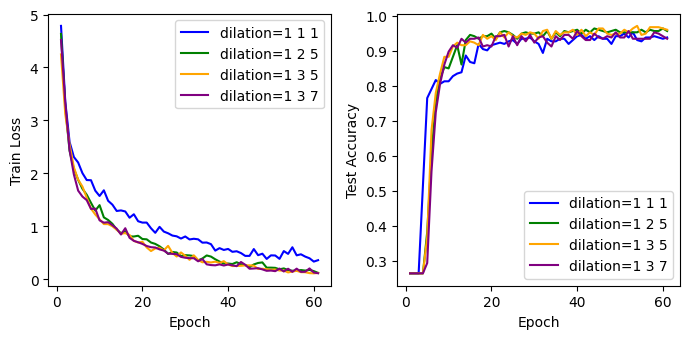

In [12]:
class Model_Vehicle_CLS_2_1(nn.Module):
    def __init__(self, num_classes=3):
        super(Model_Vehicle_CLS_2_1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 32)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class Model_Vehicle_CLS_2_2(nn.Module):
    def __init__(self, num_classes=3):
        super(Model_Vehicle_CLS_2_2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=5, dilation=5, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=5, dilation=5, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 32)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class Model_Vehicle_CLS_2_3(nn.Module):
    def __init__(self, num_classes=3):
        super(Model_Vehicle_CLS_2_3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=3, dilation=3, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=5, dilation=5, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=3, dilation=3, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=5, dilation=5, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 32)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class Model_Vehicle_CLS_2_4(nn.Module):
    def __init__(self, num_classes=3):
        super(Model_Vehicle_CLS_2_4, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=3, dilation=3, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=7, dilation=7, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=3, dilation=3, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=7, dilation=7, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 32)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


if __name__ == "__main__":
    num_epochs = 61
    learning_rate = 1e-4
    batch_size = 256
    plt.figure(figsize=(7, 3.5))
    color = ["blue", "green", "orange", "purple"]
    dilations = [
        ["[[1, 1, 1], [1, 1, 1]]", "[[1, 2, 5], [1, 2, 5]]", "[[1, 3, 5], [1, 3, 5]]", "[[1, 3, 7], [1, 3, 7]]"],
        ["1 1 1", "1 2 5", "1 3 5", "1 3 7"],
    ]
    models = [
        Model_Vehicle_CLS_2_1, 
        Model_Vehicle_CLS_2_2, 
        Model_Vehicle_CLS_2_3,
        Model_Vehicle_CLS_2_4,
    ]
    for i in range(4):
        model = models[i]()
        print("Dilation: " + dilations[0][i])
        train_loss, test_acc = train_Vehicle_CLS(model=model, learning_rate=learning_rate,
                                                 batch_size=batch_size, num_epochs=num_epochs)
        print()
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_loss, label=f'dilation={dilations[1][i]}', color=color[i])
        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), test_acc, label=f'dilation={dilations[1][i]}', color=color[i])
        torch.cuda.empty_cache()
    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

可以观察到，在收敛之前，dilation=\[\[1, 1, 1\], \[1, 1, 1\]\]的普通卷积的`Loss`相较于空洞卷积下降更慢，说明空洞卷积模型有更好的拟合能力。

# 3. 残差网络实验

- 实现给定结构的残差网络，在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）


Epoch [1/61], Train Loss: 3.3428688645, Train Time: 941.70ms, Test Acc: 26.471%, Test Time: 332.01ms
Epoch [16/61], Train Loss: 0.0355341195, Train Time: 894.17ms, Test Acc: 92.279%, Test Time: 323.26ms
Epoch [31/61], Train Loss: 0.0493925237, Train Time: 907.06ms, Test Acc: 93.015%, Test Time: 328.41ms
Epoch [46/61], Train Loss: 0.0067726109, Train Time: 898.65ms, Test Acc: 93.015%, Test Time: 345.84ms
Epoch [61/61], Train Loss: 0.1652688184, Train Time: 903.14ms, Test Acc: 93.750%, Test Time: 324.92ms
最大显存使用量: 2520.82MiB


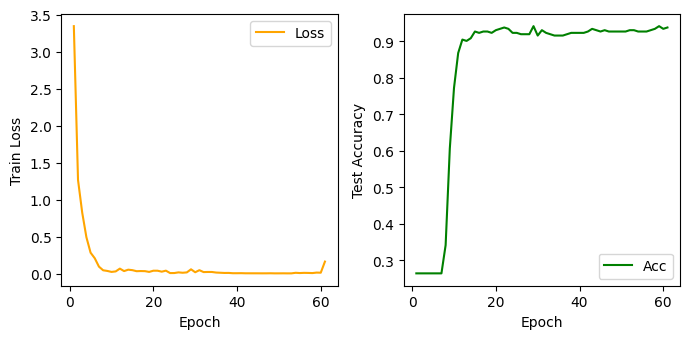

In [13]:
class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Model_Vehicle_CLS_3(nn.Module):
    def __init__(self, num_classes=3):
        super(Model_Vehicle_CLS_3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.conv2 = BasicResidualBlock(in_channels=64, out_channels=64)
        self.conv3 = BasicResidualBlock(in_channels=64, out_channels=64)
        self.conv4 = BasicResidualBlock(in_channels=64, out_channels=128, stride=2)
        self.conv5 = BasicResidualBlock(in_channels=128, out_channels=128)
        self.conv6 = BasicResidualBlock(in_channels=128, out_channels=256, stride=2)
        self.conv7 = BasicResidualBlock(in_channels=256, out_channels=256)
        self.conv8 = BasicResidualBlock(in_channels=256, out_channels=512, stride=2)
        self.conv9 = BasicResidualBlock(in_channels=512, out_channels=512)
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


if __name__ == "__main__":
    num_epochs = 61
    learning_rate = 15e-5
    batch_size = 512
    plt.figure(figsize=(7, 3.5))
    model = Model_Vehicle_CLS_3(num_classes=3)
    train_loss, test_acc = train_Vehicle_CLS(model=model, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_loss, label=f'Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_acc, label=f'Acc', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    torch.cuda.empty_cache()

实验证明，残差网络的效果比纯卷积网络好。原因在于残差网络能保留原图片输入的大部分特征，不会在卷积计算中遗漏。

# 心得体会

通过本次卷积神经网络实验，我深入理解和掌握了卷积神经网络的原理，并且在多个数据集上设计并训练了不同结构的卷积神经网络模型，通过比较分析不同模型的性能，加深了我对卷积神经网络中不同组件作用的理解。

实验中，我实现了自定义的二维卷积运算，并在车辆分类任务上与PyTorch内置的二维卷积运算进行了比较。这让我深入理解了卷积运算转换为矩阵运算的过程，以及GPU对矩阵运算的加速优化。我也对比研究了卷积层数、卷积核大小等超参数对模型性能的影响。

通过对dilation参数的研究，我意识到在神经网络设计中参数选择的细微差别可能导致显著的性能变化。特别是在对比普通卷积和不同dilation配置的空洞卷积时，我观察到虽然较高的dilation在一开始的学习效率和准确率方面可能不如普通卷积，但随着训练的进行，它们能更好地拟合数据且较不易过拟合。这种洞见对我理解如何平衡网络的学习速度和泛化能力非常有帮助。

此外，通过残差网络的实验，我学到了网络结构设计的重要性。残差网络能够有效地解决深度网络训练过程中的梯度消失问题，同时保留更多的原始特征信息。这一点在实验中得到了明显的体现，残差网络在几乎所有指标上都优于传统的纯卷积网络。

在实验过程中，我也遇到了一些挑战，比如调整网络参数以避免过拟合，以及理解不同网络结构背后的理论基础。通过不断尝试和阅读相关文献，我逐步克服了这些难题，并对这些概念有了更深刻的理解。

通过整个实验，我掌握了卷积神经网络的组成结构，了解了调节不同超参数对模型性能的影响，加深了对卷积神经网络代表性结构的理解，为后续课程项目奠定了基础。我会在今后的学习中进一步深化对卷积神经网络的研究，运用到更多实际问题中。这次实验不仅增强了我的技术技能，也加深了我对深度学习领域的热情和认识。我期待未来能在这一领域继续探索和成长。